In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/damage_severity/

/content/drive/MyDrive/damage_severity


In [ ]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

from sklearn.utils import shuffle
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/damage_severity/train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/damage_severity/valid.csv")
test_df = pd.read_csv("/content/drive/MyDrive/damage_severity/test.csv")


# Shuffle DataFrames
train_df = shuffle(train_df)
valid_df = shuffle(valid_df)
test_df = shuffle(test_df)

# Reset index after shuffling
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

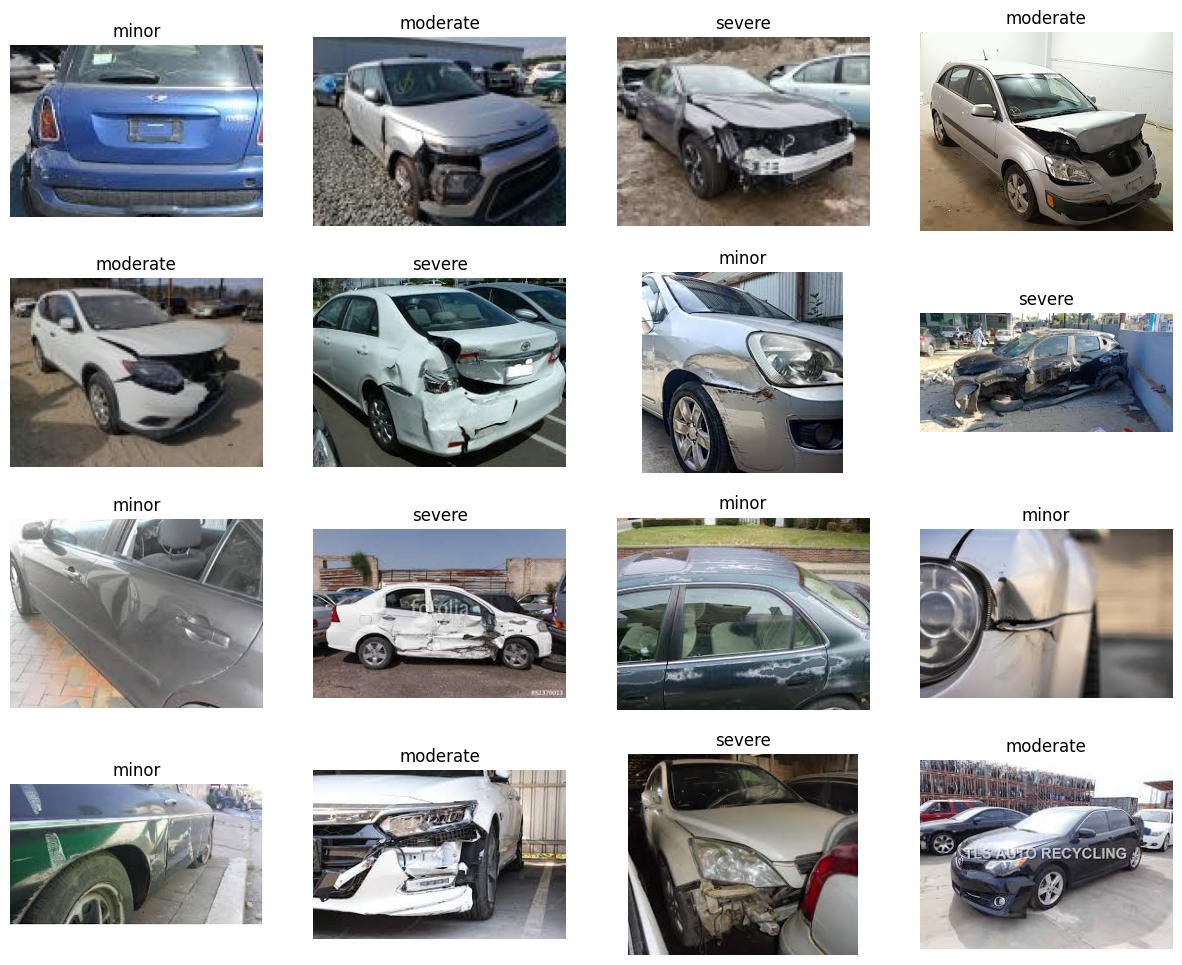

In [ ]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["label"])
    plt.axis('off')
plt.show()

In [ ]:
# Count the number of real and fake images in each set
def count_labels(df):
    minor_count = df[df['label'] == 'minor'].shape[0]
    moderate_count = df[df['label'] == 'moderate'].shape[0]
    severe_count = df[df['label'] == 'severe'].shape[0]
    return minor_count, moderate_count, severe_count

# Count for train set
train_minor_count, train_moderate_count , train_severe_count = count_labels(train_df)
print(f"Train set - minor: {train_minor_count}, moderate: {train_moderate_count}, severe: {train_severe_count}")

# Count for validation set
validation_minor_count, validation_moderate_count , validation_severe_count = count_labels(valid_df)
print(f"Validation set - minor: {validation_minor_count}, moderate: {validation_moderate_count}, severe: {validation_severe_count}")

# Count for test set
test_minor_count, test_moderate_count, test_severe_count = count_labels(test_df)
print(f"Test set - minor: {test_minor_count}, moderate: {test_moderate_count}, severe: {test_severe_count}")

Train set - minor: 434, moderate: 445, severe: 452
Validation set - minor: 82, moderate: 75, severe: 91
Test set - minor: 72, moderate: 71, severe: 85


In [ ]:
# Print the lengths of the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 1331
Validation set size: 248
Test set size: 228


In [ ]:
lb = LabelEncoder()

# Encode labels to numerical values
train_df['label'] = lb.fit_transform(train_df['label'])
valid_df['label'] = lb.transform(valid_df['label'])
test_df['label'] = lb.transform(test_df['label'])
train_df.head()

,path,label
0,/content/drive/MyDrive/damage_severity_dataset...,2
1,/content/drive/MyDrive/damage_severity_dataset...,1
2,/content/drive/MyDrive/damage_severity_dataset...,2
3,/content/drive/MyDrive/damage_severity_dataset...,1
4,/content/drive/MyDrive/damage_severity_dataset...,2


In [ ]:

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:
# Assuming you have three classes, adjust accordingly
num_classes = 3
img_width, img_height= 224, 224
batch_size= 32
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=lambda x: tf.image.resize(x, (img_width, img_height))
)

# Create a data generator for the training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',  # Adjust this to match the actual column name
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create a data generator for the validation set
validation_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',  # Adjust this to match the actual column name
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Create a data generator for the test set (without using 'subset')
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',  # Adjust this to match the actual column name
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 1065 validated image filenames belonging to 3 classes.
Found 49 validated image filenames belonging to 3 classes.
Found 228 validated image filenames belonging to 3 classes.


## CNN model

In [ ]:
num_classes = 3

# Build the CNN model
model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and feed it into dense layers
model_cnn.add(Flatten())

model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))  # Add dropout for regularization

# Output layer
model_cnn.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
model_checkpoint = ModelCheckpoint('cnn.h5', save_best_only=True, monitor='val_accuracy', mode='max')
# Train the model
history_cnn= model_cnn.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[model_checkpoint]
)

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.3484 - accuracy: 0.3258 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 385s 11s/step - loss: 1.3484 - accuracy: 0.3258 - val_loss: 1.0831 - val_accuracy: 0.3469
Epoch 2/50
34/34 [==============================] - 21s 620ms/step - loss: 1.0701 - accuracy: 0.4094 - val_loss: 1.0533 - val_accuracy: 0.4694
Epoch 3/50
34/34 [==============================] - 21s 613ms/step - loss: 1.0430 - accuracy: 0.4770 - val_loss: 0.9749 - val_accuracy: 0.5714
Epoch 4/50
34/34 [==============================] - 23s 687ms/step - loss: 1.0201 - accuracy: 0.4714 - val_loss: 0.9755 - val_accuracy: 0.6327
Epoch 5/50
34/34 [==============================] - 19s 554ms/step - loss: 1.0113 - accuracy: 0.4761 - val_loss: 0.9280 - val_accuracy: 0.5714
Epoch 6/50
34/34 [==============================] - 20s 575ms/step - loss: 0.9730 - accuracy: 0.5099 - val_loss: 0.9273 - val_accuracy: 0.5102
Epoch 7/50
34/34 [==============================] - 18s 536ms/step - loss: 0.9678 - accuracy: 0.5305 - val_loss: 0.9507 - val_accuracy: 0.5918
Epoch 8/50


In [ ]:
import numpy as np
test_loss, test_accuracy = model_cnn.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Get predictions for the test set
predictions = model_cnn.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

8/8 [==============================] - 67s 10s/step - loss: 1.6623 - accuracy: 0.5175
Test Accuracy: 51.75%
Test Loss: 1.6623
8/8 [==============================] - 5s 639ms/step


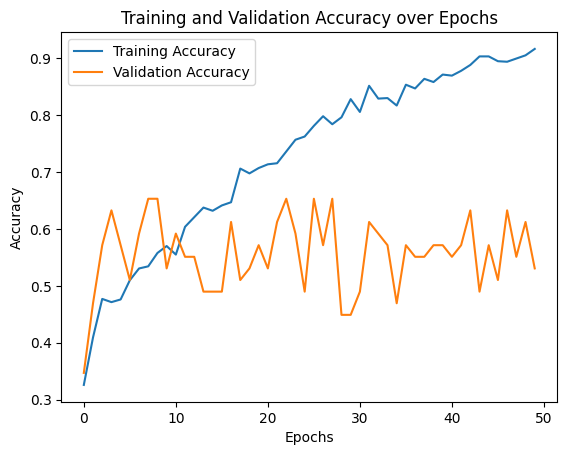

8/8 [==============================] - 3s 381ms/step - loss: 1.7867 - accuracy: 0.5351
Test Accuracy: 53.51%
Test Loss: 1.7867


In [ ]:
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_loss, test_accuracy = model_cnn.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

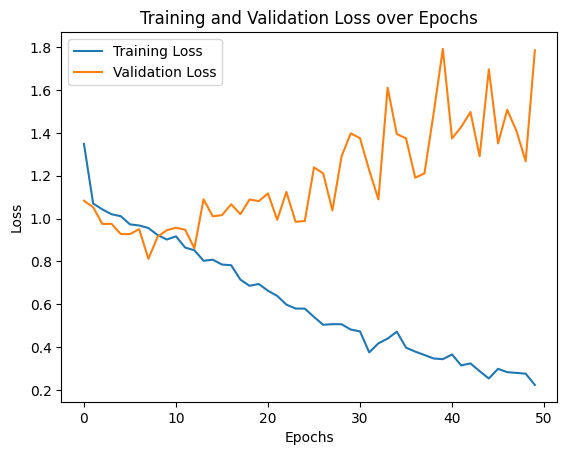

In [ ]:
all_train_loss_histories = [history_cnn.history['loss']]
all_val_loss_histories = [history_cnn.history['val_loss']]

plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

              precision    recall  f1-score   support

           0       0.58      0.29      0.39        72
           1       0.38      0.44      0.41        71
           2       0.54      0.69      0.61        85

    accuracy                           0.49       228
   macro avg       0.50      0.47      0.47       228
weighted avg       0.50      0.49      0.47       228



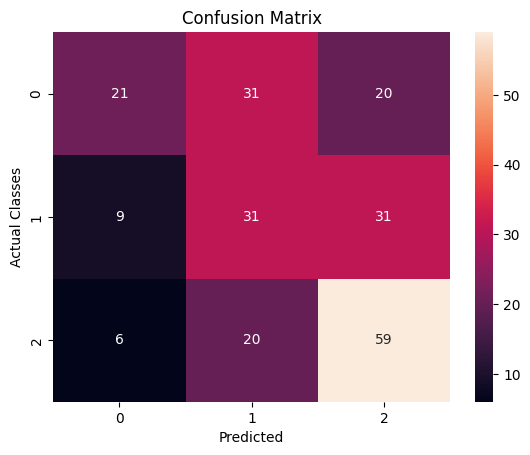

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
true_labels = test_generator.classes
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

# **DenseNet**

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import F1Score

img_size = (224, 224)
lr = 0.001
class_count = 3

img_shape = (img_size[0], img_size[1], 3)

base_model = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.015),
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model_dens = Model(inputs=base_model.input, outputs=output)
model_dens.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy',
              metrics=['accuracy','AUC'])

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
epochs=50
model_checkpoint = ModelCheckpoint('denseNet.h5', save_best_only=True, monitor='val_accuracy', mode='max')
# Train the model
history_dens = model_dens.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,

)

# Save training and validation histories for later analysis
all_train_histories = [history_dens.history['accuracy']]
all_val_histories = [history_dens.history['val_accuracy']]

Epoch 1/50
34/34 [==============================] - 143s 1s/step - loss: 6.8026 - accuracy: 0.4930 - auc: 0.6886 - val_loss: 8.1842 - val_accuracy: 0.3673 - val_auc: 0.4980
Epoch 2/50
34/34 [==============================] - 30s 872ms/step - loss: 4.9773 - accuracy: 0.5953 - auc: 0.7827 - val_loss: 9.1575 - val_accuracy: 0.3265 - val_auc: 0.5447
Epoch 3/50
34/34 [==============================] - 30s 872ms/step - loss: 4.2659 - accuracy: 0.6601 - auc: 0.8239 - val_loss: 5.0589 - val_accuracy: 0.4490 - val_auc: 0.6263
Epoch 4/50
34/34 [==============================] - 31s 903ms/step - loss: 3.7546 - accuracy: 0.7427 - auc: 0.8763 - val_loss: 3.5797 - val_accuracy: 0.6531 - val_auc: 0.8609
Epoch 5/50
34/34 [==============================] - 30s 886ms/step - loss: 3.3888 - accuracy: 0.7831 - auc: 0.9134 - val_loss: 4.8555 - val_accuracy: 0.5306 - val_auc: 0.6672
Epoch 6/50
34/34 [==============================] - 30s 885ms/step - loss: 3.0959 - accuracy: 0.7906 - auc: 0.9234 - val_loss: 

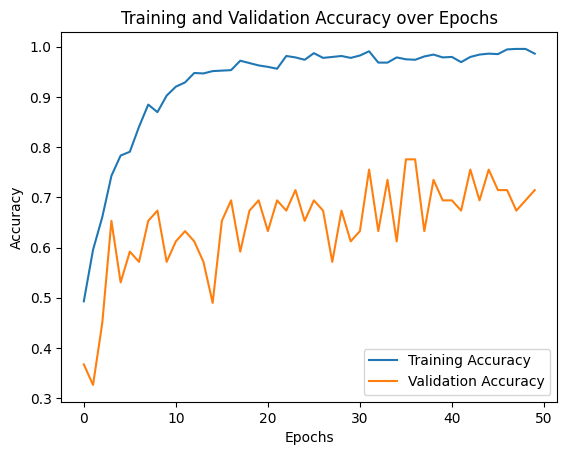

8/8 [==============================] - 6s 836ms/step - loss: 1.1390 - accuracy: 0.6667 - auc: 0.8308


In [ ]:
plt.plot(history_dens.history['accuracy'], label='Training Accuracy')
plt.plot(history_dens.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_accuracy = model_dens.evaluate(test_generator)

8/8 [==============================] - 7s 459ms/step
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        72
           1       0.51      0.61      0.55        71
           2       0.87      0.69      0.77        85

    accuracy                           0.67       228
   macro avg       0.68      0.67      0.67       228
weighted avg       0.69      0.67      0.68       228



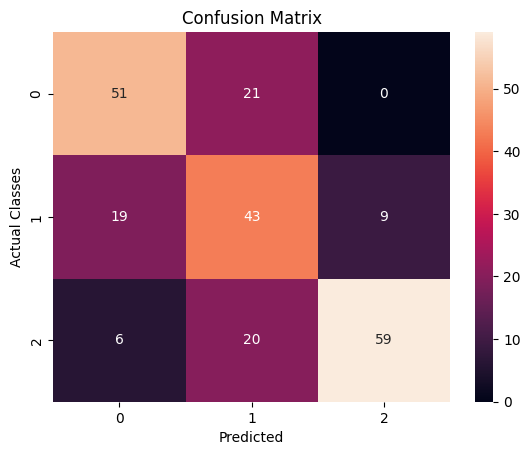

In [ ]:
# Confusion matrix
true_labels = test_generator.classes
predictions = model_dens.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [ ]:
model_dens.save('denseNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Efficient Net model**

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Number of classes in your classification task
num_classes = 3

from tensorflow.keras.applications import EfficientNetB7  # or another variant

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Build your classification model on top of EfficientNetB7
model_eff = Sequential()
model_eff.add(base_model)
model_eff.add(GlobalAveragePooling2D())
model_eff.add(Dense(256, activation='relu'))
model_eff.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_eff.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=[Accuracy()])

# Display model summary
model_eff.summary()

258076736/258076736 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               655616    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 64754074 (247.02 MB)
Trainable params: 64443347 (245.83 MB)
Non-trainable params: 310727 (1.19 MB)
______

In [ ]:
model_checkpoint = ModelCheckpoint('efficientNet.h5', save_best_only=True, monitor='val_accuracy', mode='max')
model_eff.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    batch_size=8 # Adjust the batch size based on available memory
)



Epoch 1/50


# Inception v3

In [ ]:
# Build the model
inception_model = Sequential()


base_model = InceptionV3(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')  # Change to InceptionV3

base_model.trainable = False

inception_model.add(base_model)
inception_model.add(Flatten())
inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(3, activation='softmax'))
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 28356899 (108.17 MB)
Trainable params: 6554115 (25.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Compile the model
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_inception=inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
33/33 [==============================] - 300s 9s/step - loss: 10.2369 - accuracy: 0.3950 - val_loss: 1.0599 - val_accuracy: 0.2500
Epoch 2/50
33/33 [==============================] - 134s 4s/step - loss: 1.0488 - accuracy: 0.3756 - val_loss: 1.0447 - val_accuracy: 0.3750
Epoch 3/50
33/33 [==============================] - 129s 4s/step - loss: 0.9830 - accuracy: 0.4821 - val_loss: 0.9096 - val_accuracy: 0.5625
Epoch 4/50
33/33 [==============================] - 126s 4s/step - loss: 1.0027 - accuracy: 0.4560 - val_loss: 0.9368 - val_accuracy: 0.6562
Epoch 5/50
33/33 [==============================] - 127s 4s/step - loss: 0.9640 - accuracy: 0.4734 - val_loss: 0.9629 - val_accuracy: 0.5000
Epoch 6/50
33/33 [==============================] - 132s 4s/step - loss: 0.9493 - accuracy: 0.4898 - val_loss: 0.8017 - val_accuracy: 0.6562
Epoch 7/50
33/33 [==============================] - 126s 4s/step - loss: 0.9018 - accuracy: 0.4850 - val_loss: 0.8183 - val_accuracy: 0.6250
Epoch 8/50
3

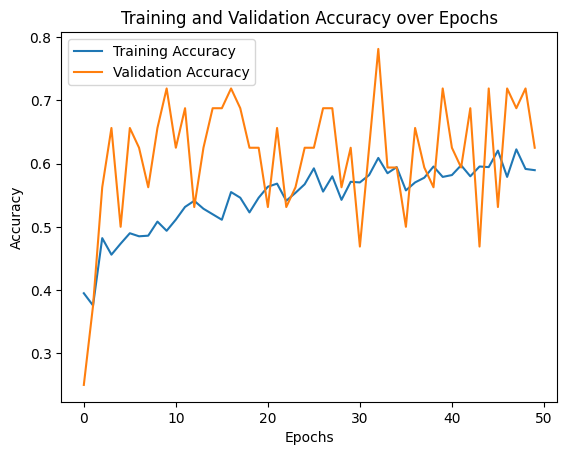

8/8 [==============================] - 60s 8s/step - loss: 0.7270 - accuracy: 0.6886


In [ ]:
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_accuracy = inception_model.evaluate(test_generator)

8/8 [==============================] - 31s 3s/step
              precision    recall  f1-score   support

           0       0.79      0.62      0.70        72
           1       0.49      0.66      0.57        71
           2       0.83      0.74      0.78        85

    accuracy                           0.68       228
   macro avg       0.70      0.68      0.68       228
weighted avg       0.71      0.68      0.69       228



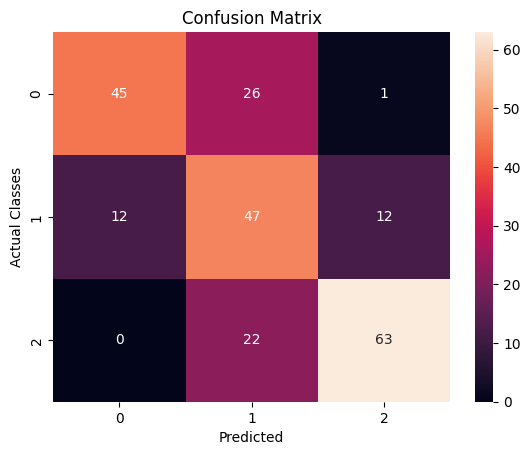

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns
true_labels = test_generator.classes
predictions = inception_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.62      0.70        72
           1       0.49      0.66      0.57        71
           2       0.83      0.74      0.78        85

    accuracy                           0.68       228
   macro avg       0.70      0.68      0.68       228
weighted avg       0.71      0.68      0.69       228



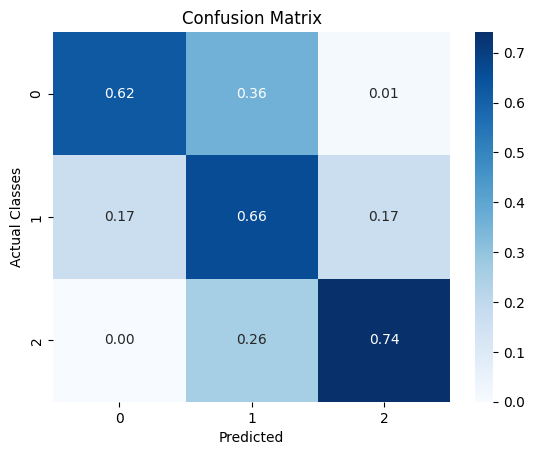

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming you have true_labels, predicted_labels, and the model_dens as given in your code

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate percentages
cm_percentages = (cm / cm.sum(axis=1)[:, np.newaxis])

# Create a heatmap with percentages formatted as values < 1
sns.heatmap(cm_percentages, annot=True, fmt=".2f", cmap="Blues")

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()


In [ ]:
inception_model.save("inception.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Resnet 50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Assuming input shape is (224, 224, 3), adjust if needed
input_shape = (224, 224, 3)
num_classes = 3

# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a new model by adding custom top layers
resnet_model = Sequential()
resnet_model.add(base_model)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

# Freeze the weights of the ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
resnet_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24113027 (91.98 MB)
Trainable params: 525315 (2.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:

# Train the model
history_resnet=resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
33/33 [==============================] - 232s 7s/step - loss: 1.1901 - accuracy: 0.3524 - val_loss: 1.0273 - val_accuracy: 0.5000
Epoch 2/50
33/33 [==============================] - 214s 6s/step - loss: 1.0278 - accuracy: 0.4414 - val_loss: 0.9299 - val_accuracy: 0.5312
Epoch 3/50
33/33 [==============================] - 212s 6s/step - loss: 0.9991 - accuracy: 0.4956 - val_loss: 0.8858 - val_accuracy: 0.5625
Epoch 4/50
33/33 [==============================] - 209s 6s/step - loss: 0.9557 - accuracy: 0.5276 - val_loss: 0.8824 - val_accuracy: 0.5938
Epoch 5/50
33/33 [==============================] - 211s 6s/step - loss: 0.9662 - accuracy: 0.5005 - val_loss: 0.8900 - val_accuracy: 0.5938
Epoch 6/50
33/33 [==============================] - 215s 7s/step - loss: 0.9749 - accuracy: 0.5121 - val_loss: 0.9023 - val_accuracy: 0.5312
Epoch 7/50
33/33 [==============================] - 214s 6s/step - loss: 0.9521 - accuracy: 0.5198 - val_loss: 0.8215 - val_accuracy: 0.6875
Epoch 8/50
33

In [ ]:
resnet_model.save("resnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-291d96e0a854>", line 1, in <cell line: 1>
    resnet_model.save("resnet.h5")
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 126, in h5py.h5f.create
OSError: [Errno 107] Unable to 